In [1]:
import sys
import csv
import datetime
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from datetime import datetime
import gender_guesser.detector as gender
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
def read_datasets():
    genuine_users=pd.read_csv("Datasets/users.csv")
    fake_users=pd.read_csv("Datasets/fusers.csv")
    x=pd.concat([genuine_users,fake_users])
    y=len(fake_users)*[0]+len(genuine_users)*[1]
    return x,y

In [3]:
def predict_sex(name):
    name=str(name)
    sex_predictor=gender.Detector(case_sensitive=False)
    first_name=name.split(' ')[0]
    sex=sex_predictor.get_gender(first_name)
    sex_dict={'female':-2,'mostly_female':-1,'unknown':0,'mostly_male':1,'male':2}
    sex_code=sex_dict[sex]
    return sex_code

In [4]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))   
    lang_dict = { name : i for i, name in lang_list }             
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code']=predict_sex(x['name'])
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x=x.loc[:,feature_columns_to_use]
    return x

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1,color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.legend(loc="best")
    return plt

In [6]:
def plot_confusion_matrix(cm,title="consufion matrix",cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm,interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(target_names))
    plt.xticks(tick_marks,target_names,rotation=45)
    plt.yticks(tick_marks,target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
def plot_roc_curve(y_test,y_pred):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test,y_pred)
    print('False Positive rate:',false_positive_rate)
    print('True Positive rate:',true_positive_rate)
    roc_auc=auc(false_positive_rate,true_positive_rate)
    plt.title("Receiver Operating Characterstics")
    plt.plot(false_positive_rate,true_positive_rate,'b',label='AUC = %0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [8]:
def trainSVM(X_train, y_train, X_test, y_test):
    """ Trains and predicts dataset with a SVM classifier """
    # Scaling features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': [0.1, 1, 'scale', 'auto']
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    classifier = SVC(kernel='rbf')
    clf = GridSearchCV(classifier, param_grid=param_grid, cv=cv)
    clf.fit(X_train, y_train)
    print("The best classifier is: ",clf.best_estimator_)
    clf.best_estimator_.fit(X_train,y_train)
    
    # Estimate score
    scores = cross_val_score(clf.best_estimator_, X_train, y_train, cv=5)
    print(scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))
    title = 'Learning Curves (SVM, rbf kernel, $\gamma=%.6f$)' %clf.best_estimator_.gamma
    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=5)
    plt.show()
    
    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)
    return y_test, y_pred

In [9]:
def trainLR(X_train, y_train, X_test, y_test):
    # Scale the features
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)

    # Set up a parameter grid for Logistic Regression hyperparameters
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

    # Use GridSearchCV to find the best hyperparameters for Logistic Regression
    cvk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    clf = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cvk)
    clf.fit(X_train, y_train)

    print("The best classifier is: ", clf.best_estimator_)
    clf.best_estimator_.fit(X_train, y_train)

    # Estimate score
    scores = cross_val_score(clf.best_estimator_, X_train, y_train, cv=5)
    print(scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))

    title = 'Learning Curves (LR)'
    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=5)
    plt.show()

    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)
    return y_test, y_pred


In [10]:
print("Reading Datasetes....\n")
x,y=read_datasets()
x.describe()

Reading Datasetes....



,id,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,...,utc_offset,is_translator,follow_request_sent,protected,verified,notifications,contributors_enabled,following,test_set_1,test_set_2
count,6.825000e+03,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,4066.0,19.0,2294.0,6426.0,...,2810.000000,1.0,0.0,78.0,11.0,0.0,0.0,0.0,3474.000000,3474.000000
mean,8.499737e+08,8667.221685,717.874432,504.022564,2378.999121,9.959853,1.0,1.0,1.0,1.0,...,-4889.145907,1.0,NaN,1.0,1.0,NaN,NaN,NaN,0.287853,0.141048
std,7.662248e+08,23473.945131,12301.657025,1159.286294,8548.235726,112.952257,0.0,0.0,0.0,0.0,...,22037.451204,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.452827,0.348121
min,6.780330e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,...,-39600.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,0.000000,0.000000
25%,2.597067e+08,23.000000,12.000000,206.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,...,-25200.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,0.000000,0.000000
50%,6.168972e+08,190.000000,33.000000,312.000000,10.000000,0.000000,1.0,1.0,1.0,1.0,...,-14400.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,0.000000,0.000000
75%,1.174963e+09,6900.000000,349.000000,555.000000,1360.000000,2.000000,1.0,1.0,1.0,1.0,...,13500.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.000000,0.000000
max,3.164942e+09,399555.000000,986837.000000,46310.000000,313954.000000,6166.000000,1.0,1.0,1.0,1.0,...,46800.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000


In [11]:
print("extracting features....\n")

x=extract_features(x)
print(x.columns)
print(x.describe())
x.describe()

extracting features....

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     6825.000000      6825.000000    6825.000000       6825.000000   
mean      8667.221685       717.874432     504.022564       2378.999121   
std      23473.945131     12301.657025    1159.286294       8548.235726   
min          0.000000         0.000000       0.000000          0.000000   
25%         23.000000        12.000000     206.000000          0.000000   
50%        190.000000        33.000000     312.000000         10.000000   
75%       6900.000000       349.000000     555.000000       1360.000000   
max     399555.000000    986837.000000   46310.000000     313954.000000   

       listed_count  sex_code    lang_code  
count   6825.000000    6825.0  6825.000000  
mean       9.959853       0.0     5.679121  
std      112

,statuses_count,followers_count,friends_count,favourites_count,listed_count,sex_code,lang_code
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.0,6825.000000
mean,8667.221685,717.874432,504.022564,2378.999121,9.959853,0.0,5.679121
std,23473.945131,12301.657025,1159.286294,8548.235726,112.952257,0.0,2.527263
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,23.000000,12.000000,206.000000,0.000000,0.000000,0.0,5.000000
50%,190.000000,33.000000,312.000000,10.000000,0.000000,0.0,5.000000
75%,6900.000000,349.000000,555.000000,1360.000000,2.000000,0.0,5.000000
max,399555.000000,986837.000000,46310.000000,313954.000000,6166.000000,0.0,25.000000


In [12]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [13]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Train SVM and LR models
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

C:\Users\harsh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [14]:
from sklearn.ensemble import VotingClassifier

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('svm', svm_model),
    ('lr', lr_model)],
    voting='soft', weights=[2, 1])
voting_clf.fit(X_train, y_train)

C:\Users\harsh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('lr', LogisticRegression())],
                 voting='soft', weights=[2, 1])

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get the predictions from the voting classifier
y_pred_voting = voting_clf.predict(X_test)

# Evaluate the performance of the voting classifier
accuracy = accuracy_score(y_test, y_pred_voting)
precision = precision_score(y_test, y_pred_voting)
recall = recall_score(y_test, y_pred_voting)
f1 = f1_score(y_test, y_pred_voting)

# Print the evaluation metrics
print("Accuracy:", accuracy*100.0)
print("Precision:", precision*100.0)
print("Recall:", recall*100.0)
print("F1-score:", f1*100.0)

Accuracy: 90.84249084249085
Precision: 87.00636942675159
Recall: 96.74220963172804
F1-score: 91.61636485580149


In [16]:
import numpy as np

# Get the output probabilities from the voting classifier
y_pred_proba_voting = voting_clf.predict_proba(X_test)

# Create a new dataset by concatenating the output probabilities with the original features
X_new = np.hstack((X_test, y_pred_proba_voting))


In [17]:

import tensorflow as tf
from tensorflow import keras

# Define a neural network architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_new.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Convert input data to a tensor
X_new_tensor = tf.convert_to_tensor(X_new)
y_test_tensor = tf.convert_to_tensor(y_test)

# Train the model
model.fit(X_new_tensor, y_test_tensor, epochs=10, batch_size=32)

Epoch 1/10
43/43 [==============================] - 2s 4ms/step - loss: 26.1446 - accuracy: 0.9377
Epoch 2/10
43/43 [==============================] - 0s 4ms/step - loss: 9.1435 - accuracy: 0.9319
Epoch 3/10
43/43 [==============================] - 0s 3ms/step - loss: 4.1668 - accuracy: 0.9223
Epoch 4/10
43/43 [==============================] - 0s 3ms/step - loss: 2.7652 - accuracy: 0.9377
Epoch 5/10
43/43 [==============================] - 0s 4ms/step - loss: 4.4688 - accuracy: 0.9473
Epoch 6/10
43/43 [==============================] - 0s 3ms/step - loss: 2.5605 - accuracy: 0.9392
Epoch 7/10
43/43 [==============================] - 0s 3ms/step - loss: 2.5281 - accuracy: 0.9451
Epoch 8/10
43/43 [==============================] - 0s 3ms/step - loss: 7.1509 - accuracy: 0.9458
Epoch 9/10
43/43 [==============================] - 0s 3ms/step - loss: 7.9432 - accuracy: 0.9516
Epoch 10/10
43/43 [==============================] - 0s 3ms/step - loss: 8.5763 - accuracy: 0.9429


In [18]:
# Get the predictions from the neural network
y_pred = model.predict(X_new)

# Convert the probabilities to binary labels
y_pred = np.where(y_pred > 0.5, 1, 0)

# Evaluate the performance of the neural network
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy*100)
print("Precision:", precision*100)
print("Recall:", recall*100)
print("F1-score:", f1*100)


43/43 [==============================] - 0s 3ms/step
Accuracy: 97.06959706959707
Precision: 98.68421052631578
Recall: 95.60906515580736
F1-score: 97.12230215827337


# from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

[[650   9]
 [ 31 675]]
Confusion matrix, without normalization
[[650   9]
 [ 31 675]]


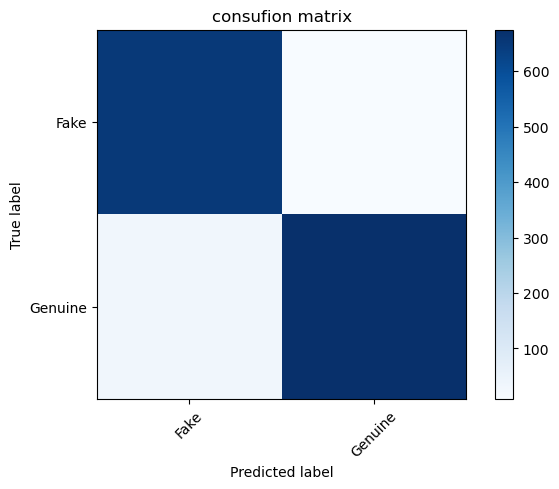

In [20]:
cnf_matrix=confusion_matrix(y_test,y_pred.round())
print(cnf_matrix)
cm=confusion_matrix(y_test, y_pred)
cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm)

Normalized confusion matrix
[[0.98634294 0.01365706]
 [0.04390935 0.95609065]]


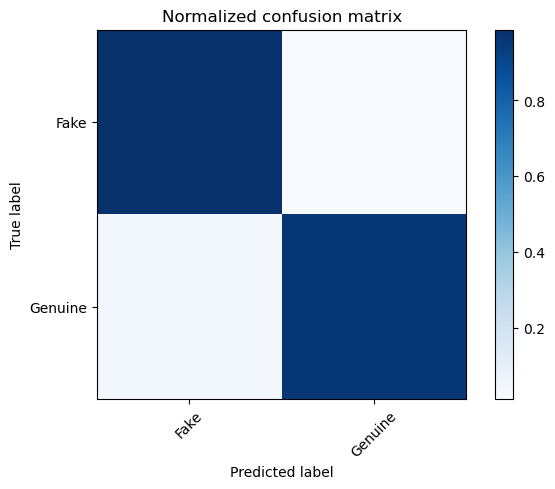

In [21]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

<AxesSubplot:>

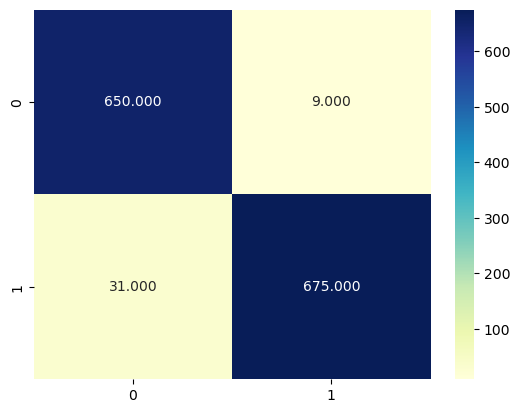

In [22]:
import seaborn as sns
labels=[0,1]
sns.heatmap(cnf_matrix,annot=True,cmap="YlGnBu",fmt='.3f',xticklabels=labels,yticklabels=labels)


False Positive rate: [0.         0.01365706 1.        ]
True Positive rate: [0.         0.95609065 1.        ]


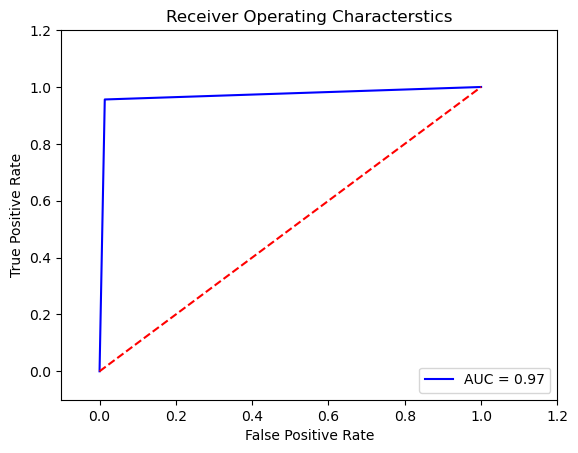

In [23]:
plot_roc_curve(y_test,y_pred)